# Compressive Gate Set Tomography (GST)
This notebook gives an introduction on how to run compressive gate set tomography, what the input parameters mean and how to display different observations and plots. 

This notebook and the compressive GST functionality **requires the optional dependency "mgst"** to be installed. \
For background, see the journal reference at https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010325

In [1]:
%load_ext autoreload
%autoreload 2
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration, CompressiveGST

import numpy as np
from iqm.benchmarks.benchmark_definition import show_figure

## Choose (or define) a backend

In [2]:
#backend = "IQMFakeAdonis"
backend = "IQMFakeApollo"
#backend = "garnet"


## Minimal GST Experiment configurations

The most important parameters are the following:
- qubits (`List[int]`): The qubits on the backend where the experiment is performed.
- gate_set (`Union[str, List[Type[QuantumCircuit]]]`): Either one of the currently predefined gate sets `"1QXYI"`, `"2QXYCZ"`, `"2QXYCZ_extended"`, `"3QXYCZ"`, or a list of quantum circuits.
- num_circuits (`int`): The number of circuits for the experiment. Recommended are at least 50 for single qubit GST, at least 300 for two-qubit GST and at least 2000 for 3-qubit GST. 
- shots (`int`): The number of shots per circuit.
- rank (`int`): The Kraus rank of the reconstruction, i.e. the number of Kraus operators for each gate.
      $$ G(\rho) = \sum_{i = 1}^{\text{rank}} K_i \rho K_i^{\dagger}$$
  Setting `rank=1` will trigger a unitary gate fit, leading to a gate parametrization output in terms Hamiltonian parameters.
  The maximum rank is given by the physical dimension squared. For fully rigorous performance computation of metrics such as the average gate fidelity or the diamond distance it is recommended to choose full rank.
  A low rank has the benefit of needing less circuits and less computing time, while still capturing the dominant error sources.
- bootstrap_samples (`int`): If bootstrapping error bars are to be generated, this variable sets the number of bootstrap runs. Recommended for trustworthy error bars are 50 samples. The default is 0, since computing bootstrap error bars is very time consuming.

In [3]:
Minimal_1Q_GST = GSTConfiguration(
    qubit_layouts=[[0]],
    gate_set="1QXYI",
    num_circuits=100,
    shots=1000,
    rank=4,
    bootstrap_samples=50,
)

Minimal_2Q_GST = GSTConfiguration(
    qubit_layouts=[[0,1]],
    gate_set="2QXYICZ",
    num_circuits=1000,
    shots=1000,
    rank=16,
    bootstrap_samples=0,
)

## Execute GST Experiment(s)
Be prepared that the first execution on a new system will take an extra 1-2 minutes to compile the lower level optimization code. 

In [4]:
benchmark = CompressiveGST(backend, Minimal_2Q_GST)
benchmark.run()
result = benchmark.analyze()

2025-07-18 17:02:28,787 - iqm.benchmarks.logging_config - INFO - Generating 1000 random GST circuits
2025-07-18 17:02:29,823 - iqm.benchmarks.logging_config - INFO - Will transpile all 1000 circuits according to fixed physical layout
2025-07-18 17:02:30,504 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-07-18 17:02:36,603 - iqm.benchmarks.logging_config - INFO - Submitting batch with 1000 circuits corresponding to qubits [0, 1]
2025-07-18 17:02:37,107 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-07-18 17:02:37,303 - iqm.benchmarks.logging_config - INFO - Retrieving all counts
2025-07-18 17:02:40,470 - iqm.benchmarks.logging_config - INFO - Adding counts to dataset
2025-07-18 17:02:44,143 - iqm.benchmarks.logging_config - INFO - Execution completed
2025-07-18 17:02:44,146 - iqm.benchmarks.logging_config - INFO - Running mGST analysis for

To get a unitary model of the gate set from the same data, the `rank` parameter of the benchmark object can be set to 1.
The analysis will give a Hamiltonian parametrization of the gate set and produce different plots.

In [5]:
from copy import deepcopy
benchmark_rK1 = deepcopy(benchmark)
benchmark_rK1.runs[0].dataset.attrs["rank"] = 1
result_rK1 = benchmark_rK1.analyze()

2025-07-18 17:03:24,808 - iqm.benchmarks.logging_config - INFO - Running mGST analysis for layout [0, 1]
2025-07-18 17:03:28,172 - iqm.benchmarks.logging_config - INFO - Starting mGST optimization...
 11%|█         | 27/250 [00:16<02:16,  1.63it/s]
2025-07-18 17:03:44,739 - iqm.benchmarks.logging_config - INFO - Convergence criterion satisfied
2025-07-18 17:03:44,739 - iqm.benchmarks.logging_config - INFO - Final objective 2.18e-4 in time 16.57s
2025-07-18 17:03:48,582 - iqm.benchmarks.logging_config - INFO - Generating figures for layout 1/1
2025-07-18 17:03:52,639 - iqm.benchmarks.logging_config - INFO - Generating additional rank 1 figures for all layouts
2025-07-18 17:03:52,879 - iqm.benchmarks.logging_config - INFO - Analysis completed


## Examine the results
### High level results stored at result.observations
For uncertaintites on the observations set `bootstrap_samples` $\geq 10$. The high level results are stored in a list of Observations under `restult.observations`.
To access only those observations corresponding to a specific qubit layout, one can use the identifier attribute:

In [6]:
qubit_layout = [0,1]
for observation in result.observations:
    if observation.identifier.string_identifier == str(qubit_layout):
        print(f"{observation.name}: {observation.value} +/- {observation.uncertainty}")

average_gate_fidelity_Idle:QB1:crosstalk_components=QB1__QB2: 0.99786 +/- nan
diamond_distance_Idle:QB1:crosstalk_components=QB1__QB2: 0.00482 +/- nan
unitarity_Idle:QB1:crosstalk_components=QB1__QB2: 0.99433 +/- nan
average_gate_fidelity_Rx_pi_2:QB1:crosstalk_components=QB1__QB2: 0.99423 +/- nan
diamond_distance_Rx_pi_2:QB1:crosstalk_components=QB1__QB2: 0.00819 +/- nan
unitarity_Rx_pi_2:QB1:crosstalk_components=QB1__QB2: 0.98472 +/- nan
average_gate_fidelity_Rx_pi_2:QB2:crosstalk_components=QB1__QB2: 0.99594 +/- nan
diamond_distance_Rx_pi_2:QB2:crosstalk_components=QB1__QB2: 0.00645 +/- nan
unitarity_Rx_pi_2:QB2:crosstalk_components=QB1__QB2: 0.98929 +/- nan
average_gate_fidelity_Ry_pi_2:QB1:crosstalk_components=QB1__QB2: 0.99514 +/- nan
diamond_distance_Ry_pi_2:QB1:crosstalk_components=QB1__QB2: 0.00755 +/- nan
unitarity_Ry_pi_2:QB1:crosstalk_components=QB1__QB2: 0.98716 +/- nan
average_gate_fidelity_Ry_pi_2:QB2:crosstalk_components=QB1__QB2: 0.99569 +/- nan
diamond_distance_Ry_pi_2

### Accessing the final gate set estimates for further processing
In addition to the high level observations above, the full process matrices for each gate and the full parametrizations for initial state and measurement are stored. They can be accessed under `result.dataset.attrs[f"results_layout_{qubit_layout}"]` as follows.

In [7]:
qubit_layout = [0,1]
print(result.dataset.attrs[f"results_layout_{qubit_layout}"].keys())

dict_keys(['raw_Kraus_operators', 'raw_gates', 'raw_POVM', 'raw_state', 'gauge_opt_gates', 'gauge_opt_gates_Pauli_basis', 'gauge_opt_POVM', 'gauge_opt_state', 'target_gates', 'target_gates_Pauli_basis', 'target_POVM', 'target_state', 'main_mGST_time', 'gauge_optimization_time', 'choi_evals', 'full_metrics'])


Two gate sets are saved, the raw gate set and the gauge-optimized gate set. 
In most instances the gauge-optimized gate set should be used for further processing, since it gives the gate set in the reference frame in which the target gates are defined. 

In [8]:
raw_gates = result.dataset.attrs[f"results_layout_{qubit_layout}"]["raw_gates"]
gauge_opt_gates = result.dataset.attrs[f"results_layout_{qubit_layout}"]["gauge_opt_gates"]

The `"raw_gates"` and `"gauge_opt_gates"` keys in the outcome dictionary contain a 3D numpy array, where i.e. gate #1 is accessed with `raw_results["gauge_opt_state"][0]`, and so on.

In [9]:
print(np.array_str(gauge_opt_gates[0], precision=3, suppress_small=True))

[[ 0.995+0.j     0.   +0.j    -0.002+0.001j -0.001-0.001j  0.   -0.j
   0.001+0.j     0.   +0.j     0.   +0.j    -0.002-0.001j  0.   -0.j
   0.001+0.j     0.   +0.j    -0.001+0.001j  0.   -0.j     0.   -0.j
   0.   +0.j   ]
 [-0.002-0.002j  0.995-0.003j  0.001-0.002j  0.001+0.001j -0.001-0.001j
  -0.001-0.j     0.   +0.j     0.   +0.j    -0.   +0.j    -0.002-0.001j
  -0.   -0.j    -0.   +0.j    -0.   -0.j    -0.001+0.001j  0.   +0.j
   0.   +0.j   ]
 [ 0.001+0.002j -0.001-0.002j  0.997-0.004j  0.002-0.j    -0.   -0.j
   0.   -0.j    -0.   -0.j     0.   +0.j    -0.   +0.j     0.   -0.j
  -0.002-0.001j  0.   -0.j     0.   -0.j    -0.   -0.j    -0.001+0.001j
  -0.   -0.j   ]
 [ 0.001-0.001j -0.001+0.001j -0.002-0.j     0.997+0.j    -0.   -0.j
  -0.   +0.j    -0.001-0.j    -0.   -0.j    -0.   +0.j     0.   +0.j
  -0.   +0.j    -0.002-0.002j  0.   +0.j     0.   -0.j    -0.   +0.j
  -0.001+0.001j]
 [-0.002+0.002j -0.001+0.001j -0.   -0.j    -0.   +0.j     0.995+0.003j
  -0.001+0.j    -0.002+

## Plots
The plots can be accessed in the notebook via result.plots, a dictionary containing all figure objects. These can then be diplayed as shown below, or saved to disc from the notebook. 
Currently all gauge optimized gate superoperators are shown as matrix plots in their Pauli basis representation, while the state preparation and measurement outcomes are shown as matrix plots in standard basis. 
For reference, a sinlge qubit superoperator for gate $G$ in the Pauli-basis has entries $G_{ij}$ defined via 
$$
G(\rho) = \frac{1}{2} \sum_{i,j = 1}^4 G_{ij} P_i Tr(P_j \rho),
$$
where $P_i, P_j$ are Pauli matrices. 

In addition to gate plots, selections of gate error measures and gate parameters are also stored in figure objects.

Stored plot names can be displayed and individually plotted as follows.

['layout_[0, 1]_choi_eigenvalues', 'layout_[0, 1]_gate_metrics', 'layout_[0, 1]_other_metrics', 'layout_[0, 1]_process_matrix_0', 'layout_[0, 1]_process_matrix_1', 'layout_[0, 1]_process_matrix_2', 'layout_[0, 1]_process_matrix_3', 'layout_[0, 1]_process_matrix_4', 'layout_[0, 1]_process_matrix_5', 'layout_[0, 1]_SPAM_matrices_real', 'layout_[0, 1]_SPAM_matrices_imag']


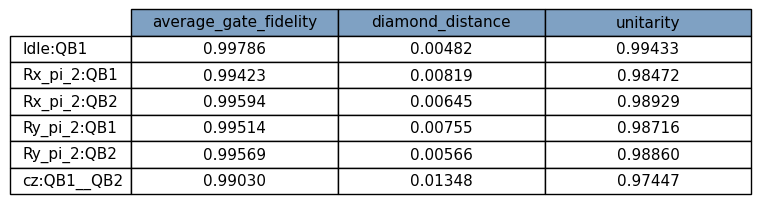

In [10]:
print(list(result.plots.keys()))
result.plot('layout_[0, 1]_gate_metrics')

### Interpretation of rank 1 results
The rank 1 results are parametrized gate Hamiltonians in the Pauli basis, which for two qubits is defined as
$$
U = e^{i H} \quad \text{with} \quad H = \frac{\pi}{2} \sum_{a, a' \in \{I, X, Y, Z\}} h_{a, a'}\, \sigma_{a} \otimes \sigma_{a'}.
$$
Here $\sigma_I$ is the single qubit identity operator, $\sigma_X$, $\sigma_Y$, and $\sigma_Z$ are the Pauli operators, and $h_{a, a'}$ are the Hamiltonian parameters.
For example, the CZ gate in this parametrization is defined by the Hamiltonian
$$
H_{\text{CZ}} = \frac{\pi}{2} \left(-\frac{1}{2}\sigma_{I}\otimes \sigma_{I} +\frac{1}{2}\sigma_{Z} \otimes \sigma_{I} +\frac{1}{2}\sigma_{I} \otimes \sigma_{Z} - \frac{1}{2}\sigma_{Z} \otimes \sigma_{Z} \right).
$$
So for instance, a perfect single qubit $\pi/2$ pulse on the first qubit is given by $h_{X, I} = 0.5$ and $h_{a, a'} = 0 \enspace \forall \enspace (a,a')\neq (X,I)$.

Two plots are generated for each gate, one showing the Hamiltonian parameters in the Pauli basis, and one showing the largest deviations from the ideal Hamiltonian.

['layout_[0, 1]_gate_metrics', 'layout_[0, 1]_other_metrics', 'layout_[0, 1]_process_matrix_0', 'layout_[0, 1]_process_matrix_1', 'layout_[0, 1]_process_matrix_2', 'layout_[0, 1]_process_matrix_3', 'layout_[0, 1]_process_matrix_4', 'layout_[0, 1]_process_matrix_5', 'layout_[0, 1]_SPAM_matrices_real', 'layout_[0, 1]_SPAM_matrices_imag', 'layout_[0, 1]_Idle:QB1_Hamiltonian', 'layout_[0, 1]_Idle:QB1_largest_coherent_errs', 'layout_[0, 1]_Rx_pi_2:QB1_Hamiltonian', 'layout_[0, 1]_Rx_pi_2:QB1_largest_coherent_errs', 'layout_[0, 1]_Rx_pi_2:QB2_Hamiltonian', 'layout_[0, 1]_Rx_pi_2:QB2_largest_coherent_errs', 'layout_[0, 1]_Ry_pi_2:QB1_Hamiltonian', 'layout_[0, 1]_Ry_pi_2:QB1_largest_coherent_errs', 'layout_[0, 1]_Ry_pi_2:QB2_Hamiltonian', 'layout_[0, 1]_Ry_pi_2:QB2_largest_coherent_errs', 'layout_[0, 1]_cz:QB1__QB2_Hamiltonian', 'layout_[0, 1]_cz:QB1__QB2_largest_coherent_errs']


(None, None)

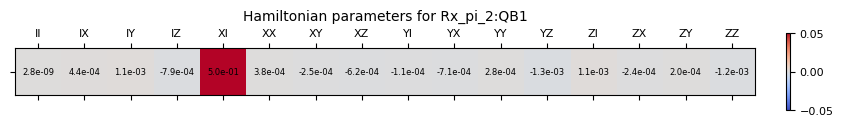

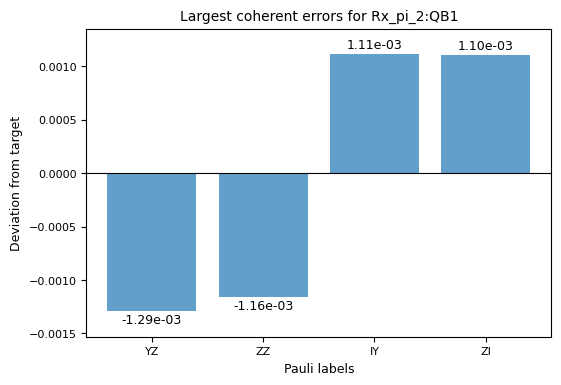

In [11]:
# Display all plot names
print(list(result_rK1.plots.keys()))
# Show two exammple plots for the Rx_pi/2 gate on qubit 0
fig_1 = result_rK1.plot('layout_[0, 1]_Rx_pi_2:QB1_Hamiltonian')
fig_2 = result_rK1.plot('layout_[0, 1]_Rx_pi_2:QB1_largest_coherent_errs')
show_figure(fig_1), show_figure(fig_2)

Alternatively, all plots (of all layouts) can be displayed via `result.plot_all()`.

## Creating a custom gate set with context circuits

In this example we define a gate set ourselves as a list of quantum circuits. The example gate set chosen here is the "XYI" gate set with the addition of $\pi$-rotations around the X- and Y-axis. 
Note the number of random gate sequences also needs to be increased if the gate set is extended.

To account for realistic noise, we can add gates that act simultaneously on other qubits, for instance, a layer of CZ gates. We refer to this as a "context" for the gate set.

In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RGate

# Define a list of gate instructions
gate_list = [RGate(1e-10, 0), RGate(0.5 * np.pi, 0), RGate(0.5 * np.pi, np.pi / 2), RGate(np.pi, 0), RGate(np.pi, np.pi / 2)]
# Define the gate set as a list of circuits, each with one gate instruction
gate_set = [QuantumCircuit(1, 0) for _ in range(len(gate_list))]
for i, gate in enumerate(gate_list):
    gate_set[i].append(gate, [0])
# Define the gate names (to be used for indentification and in plots/tables)
gate_labels = ["Idle", "Rx(pi/2)", "Ry(pi/2)", "Rx(pi)", "Ry(pi)"]

# Checking the gate set for correctness
for gate in gate_set:
    print(gate)

   ┌────────┐
q: ┤ R(0,0) ├
   └────────┘
   ┌──────────┐
q: ┤ R(π/2,0) ├
   └──────────┘
   ┌────────────┐
q: ┤ R(π/2,π/2) ├
   └────────────┘
   ┌────────┐
q: ┤ R(π,0) ├
   └────────┘
   ┌──────────┐
q: ┤ R(π,π/2) ├
   └──────────┘


### Define a context circuit for each gate

The context can be either a single circuit that is added to all gates, or a list of circuits with the same length as the gate set. Each context circuit is defined on the whole backend, while in contrast we defined the gate set above just on one qubit. The reason is that we can now control on which qubits the actual GST gates are applied with the `qubit_layouts` parameter in the GST configuration. It is also possible to run GST in parallel on multiple qubit layouts, while applying the context circuits on qubits outside the layout simultaneously.

In case there is a conflict between qubits used for GST and the qubits on which the context circuit is defined, an error will be raised.
Both the gate set and the context circuits are only transpiled to the backend but not optimized in any way, since this could lead to inconsistency in the result interpretation.

Furthermore, the context circuits need to be defined on the whole backend, to ensure that they are applied on the correct qubits.

In [13]:
# First get the backend object
from iqm.benchmarks.utils import get_iqm_backend
backend = get_iqm_backend("IQMFakeApollo")
# Define context circuits for each gate
gate_context = [QuantumCircuit(backend.num_qubits) for _ in range(5)]
# Add a CZ gate between qubits 1 and 2 to each context circuit
for gate in gate_context:
    gate.cz(1,2)
# Visualize the circuit ignoring idling qubits
gate_context[0].draw(idle_wires=False)

q_1: ─■─
      │ 
q_2: ─■─

In [14]:
CUSTOM_1Q_GST = GSTConfiguration(
    qubit_layouts=[[0]],
    gate_set=gate_set,
    gate_labels = gate_labels,
    gate_context=gate_context,
    num_circuits=100,
    shots=1000,
    rank=4,
    bootstrap_samples=0,
)

In [15]:
benchmark = CompressiveGST(backend, CUSTOM_1Q_GST)
benchmark.run()
result = benchmark.analyze()

2025-07-18 17:03:56,615 - iqm.benchmarks.logging_config - INFO - Generating 100 random GST circuits
2025-07-18 17:03:56,642 - iqm.benchmarks.logging_config - INFO - Will transpile all 100 circuits according to fixed physical layout
2025-07-18 17:03:56,690 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-07-18 17:03:57,546 - iqm.benchmarks.logging_config - INFO - Submitting batch with 100 circuits corresponding to qubits [0]
2025-07-18 17:03:57,626 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-07-18 17:03:57,753 - iqm.benchmarks.logging_config - INFO - Retrieving all counts
2025-07-18 17:03:58,320 - iqm.benchmarks.logging_config - INFO - Adding counts to dataset
2025-07-18 17:03:58,572 - iqm.benchmarks.logging_config - INFO - Run completed
2025-07-18 17:03:58,575 - iqm.benchmarks.logging_config - INFO - Running mGST analysis for layout [0]


### Checking out the process matrix corresponding to the pi rotation around the y-axis

In [16]:
gauge_opt_gates = result.dataset.attrs[f"results_layout_{str([0])}"]["gauge_opt_gates"]
print(np.array_str(gauge_opt_gates[4], precision=3, suppress_small=True))

[[ 0.005+0.j     0.   +0.001j  0.   -0.001j  0.998+0.j   ]
 [ 0.   -0.001j  0.   +0.001j -0.996+0.004j  0.001+0.002j]
 [ 0.   +0.001j -0.996-0.004j  0.   -0.001j  0.001-0.002j]
 [ 0.995+0.j    -0.   -0.001j -0.   +0.001j  0.002+0.j   ]]


### All plots for the custom gate set

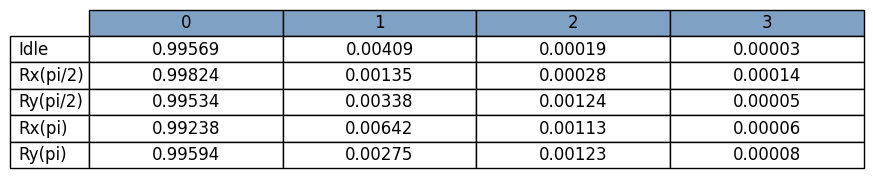

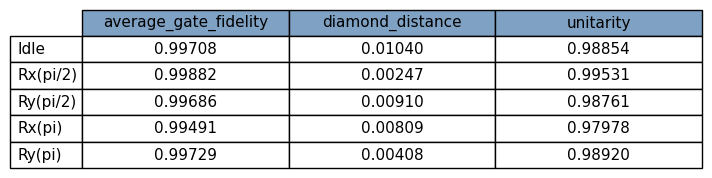

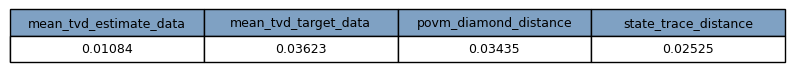

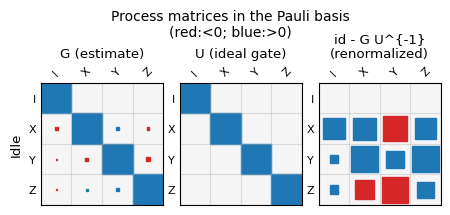

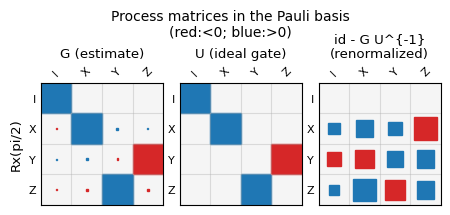

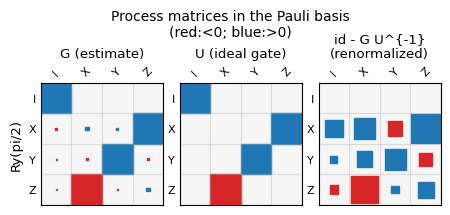

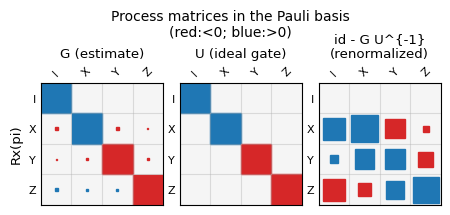

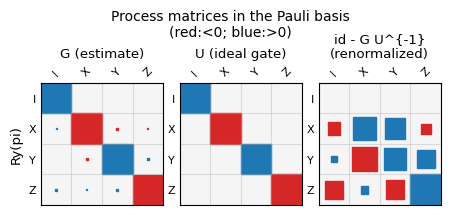

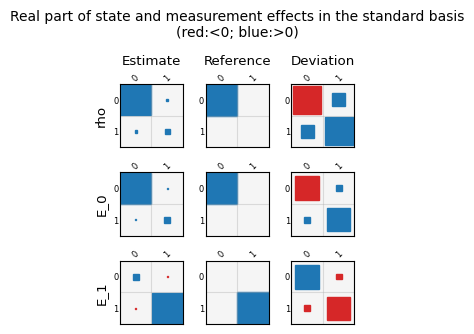

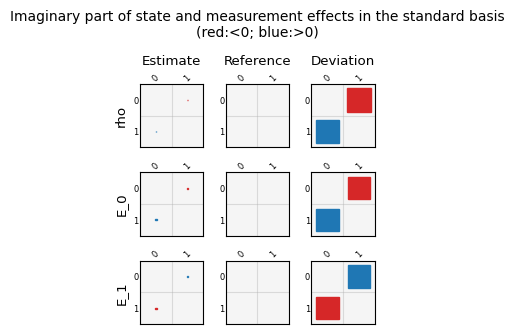

In [17]:
result.plot_all()